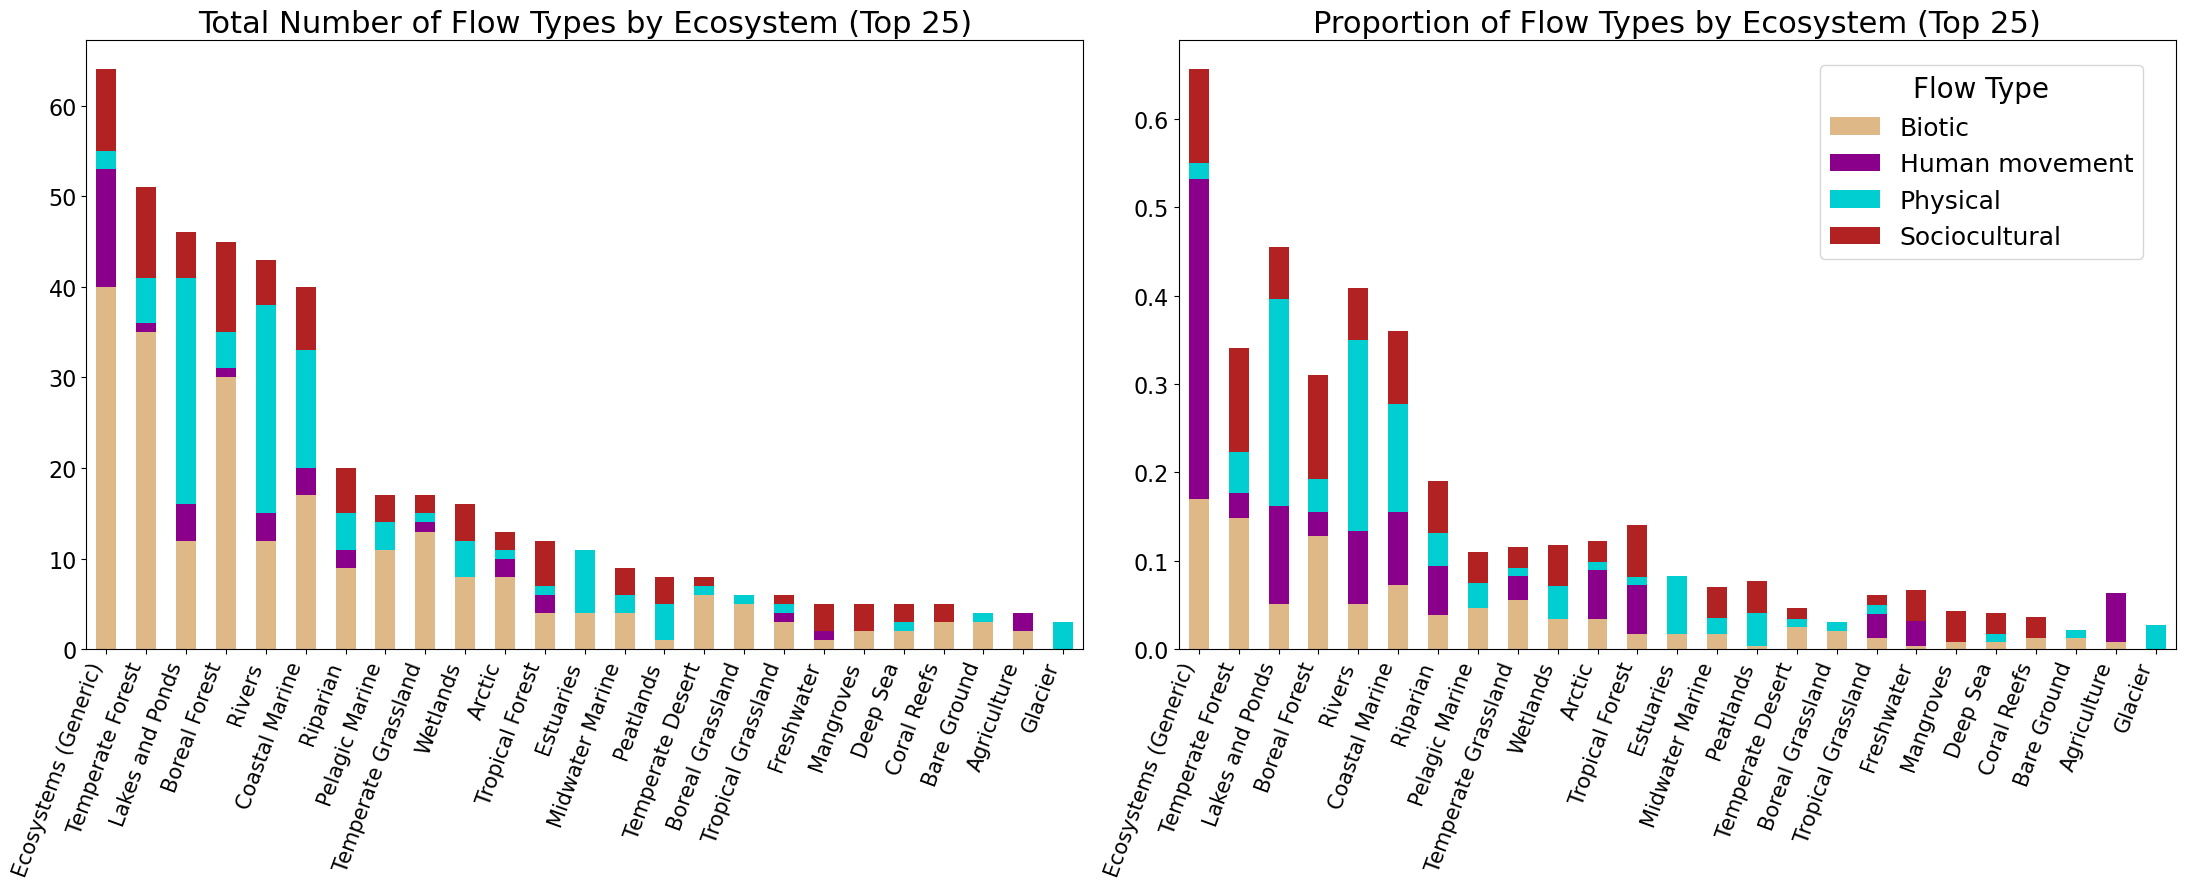

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# load dataset
df = pd.read_csv("path")

# Split and explode ecosystem types and flow types
df['EcosystemType'] = df['X2.14.Ecosystem.Type'].astype(str).str.split(',')
df['FlowType'] = df['X2.1.Flow.Type'].astype(str).str.split(',')
df_exploded = df.explode('EcosystemType').explode('FlowType')

# Clean whitespace and lowercase
df_exploded['EcosystemType'] = df_exploded['EcosystemType'].str.strip().str.lower()
df_exploded['FlowType'] = df_exploded['FlowType'].str.strip()

# Remove empty or undesired values
exclude_values = {'', 'none', 'not mentioned', 'non-specific', 'nan', 'subtype unspecified', 'subgroup unspecified'}
df_exploded = df_exploded[
    (~df_exploded['EcosystemType'].isin(exclude_values)) &
    (df_exploded['FlowType'] != '')
]

# Group ecosystem types
def group_ecosystem(ecosystem):
    if 'arctic' in ecosystem or 'artic' in ecosystem or 'polar' in ecosystem or 'sea ice' in ecosystem:
        return 'Arctic'
    elif 'agricultur' in ecosystem or 'crop' in ecosystem:
        return 'Agriculture'
    elif 'lake' in ecosystem:
        return 'Lakes and Ponds'
    elif 'alpine' in ecosystem or 'subalpine' in ecosystem or 'montane forests' in ecosystem:
        return 'Alpine/Subalpine'
    elif 'boreal desert' in ecosystem:
        return 'Boreal Forest'
    elif 'very broad' in ecosystem:
        return 'Ecosystems (Generic)'
    elif 'waters' in ecosystem or 'water systems' in ecosystem or 'water (international water law)' in ecosystem:
        return 'Freshwater'
    else:
        return ecosystem.title()


df_exploded['EcosystemTypeGrouped'] = df_exploded['EcosystemType'].apply(group_ecosystem)

# Count total occurrences per ecosystem type and pull top 25 in counts
ecosystem_counts = df_exploded['EcosystemTypeGrouped'].value_counts()
top_25_ecosystems = ecosystem_counts.head(25).index
df_top = df_exploded[df_exploded['EcosystemTypeGrouped'].isin(top_25_ecosystems)]

# Custom flow type colors
flow_type_colors = {
    'Biotic': "#DEB887",       
    'Sociocultural': "#B22222",
    'Physical': "#00CED1",
    'Human movement': "#8B008B"
}

# Plot 1: Absolute Counts 
count_df = df_top.groupby(['EcosystemTypeGrouped', 'FlowType']).size().unstack(fill_value=0)
count_df = count_df.loc[count_df.sum(axis=1).sort_values(ascending=False).index]
ecosystem_order = count_df.index.tolist()  # to match in second plot

# Plot 2: Proportions
prop_df = df_top.groupby(['FlowType', 'EcosystemTypeGrouped']).size().unstack(fill_value=0)
prop_df = prop_df[ecosystem_order]  # same x-axis order
prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)

# Side-by-Side Subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 9), sharey=False)

# Bar plot 1 parameters
colors_count = [flow_type_colors.get(col, "#cccccc") for col in count_df.columns]
count_df.plot(kind='bar', stacked=True, color=colors_count, ax=axes[0])
axes[0].set_title("Total Number of Flow Types by Ecosystem (Top 25)", fontsize=22)
axes[0].tick_params(axis='x', labelrotation=70, labelsize=15)
axes[0].tick_params(axis='y', labelsize=16)
axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right')
axes[0].legend().remove()
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# Bar plot 2 parameters
colors_prop = [flow_type_colors.get(ft, "#cccccc") for ft in prop_df.index]
prop_df.T.plot(kind='bar', stacked=True, color=colors_prop, ax=axes[1])
axes[1].set_title("Proportion of Flow Types by Ecosystem (Top 25)", fontsize=22)
axes[1].tick_params(axis='x', labelrotation=70, labelsize=15)
axes[1].tick_params(axis='y', labelsize=16)
axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right')
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].legend(title="Flow Type", title_fontsize=20, fontsize=18, loc='upper right', bbox_to_anchor=(0.98, 0.98), frameon=True)

plt.tight_layout()
plt.savefig("path", dpi=300, bbox_inches="tight")
plt.show()
